# Time Series - SARIMA, SARIMAX

### What does `statsmodels` include?

"statsmodels" is a comprehensive Python package for statistical modeling and econometrics, offering features such as:

+ Linear regression, generalized linear models (GLM), and Bayesian regression

+ Time series models: AR, MA, ARMA, ARIMA, SARIMA, SARIMAX, VAR, ARCH, GARCH

+ Descriptive statistics and statistical hypothesis testing

+ Tools for autocorrelation analysis: ACF, PACF, and stationarity tests like the Dickey-Fuller test

### Main Differences: `SARIMA()` vs `SARIMAX()`:

| Feature                     | SARIMA                                      | SARIMAX                                              |
| :-------------------------- | :------------------------------------------ | :--------------------------------------------------- |
| ⚡ Computational Efficiency  | Faster, fewer parameters                    | Slower, more parameters                              |
| 🌐 External Factors         | ❌ Not supported                             | ✅ Can include promotions, holidays, weather, etc.    |
| 📥 Input Data               | Only $y_t$ (dependent variable)             | $y_t$ + exogenous variables $X_t$                    |
| 🔍 Interpretability         | Very clear (purely autoregressive/seasonal) | Harder due to regressors                             |
| 📅 Known Events             | ❌ Cannot include them                       | ✅ Yes (e.g. lockdown, campaigns, holidays)           |
| ⚙️ Model Complexity         | Simpler, fewer parameters                   | More complex, higher risk of overfitting             |
| 🧠 Model Type               | Pure time series                            | Time series + regression                             |
| ❗ Risk of Modeling Mistakes | Lower (fewer components)                    | Higher – need good quality and stationarity of $X_t$ |


###  Main parameters of `SARIMAX()` incl. `SARIMA()`:

+ `endog`: the time series (dependent variable), e.g. sales data

+ `exog`: optional matrix of exogenous variables (e.g. weather, campaigns)

+ `order`: a tuple (p, d, q) – the non-seasonal ARIMA components

    - `p`: number of autoregressive (AR) lags

    - `d`: number of differences (to achieve stationarity)

    - `q`: number of moving average (MA) lags

+ `seasonal_order`: a tuple (P, D, Q, s) – the seasonal ARIMA components

    - `P`: seasonal AR terms

    - `D`: seasonal differencing

    - `Q`: seasonal MA terms

    - `s`: season length (e.g. 12 for monthly data with yearly seasonality)

+ `trend`: optional deterministic trend - use "c" (constant), "t" (linear), or "ct" (both)




### Import the libraries:

In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Catfish Sales Data



[OPIS]

### Read the Data:

In [182]:
catfish_sales = pd.read_csv('catfish/catfish.csv')
catfish_sales.head()

,Date,Total
0,1986-1-01,9034
1,1986-2-01,9596
2,1986-3-01,10558
3,1986-4-01,9002
4,1986-5-01,9239


Convert **'Data'** `string` type to `data` type

In [183]:
catfish_sales['Date'] = pd.to_datetime(catfish_sales['Date'], format='%Y-%m-%d')
catfish_sales.head()

,Date,Total
0,1986-01-01,9034
1,1986-02-01,9596
2,1986-03-01,10558
3,1986-04-01,9002
4,1986-05-01,9239


Plot of our Time Series:

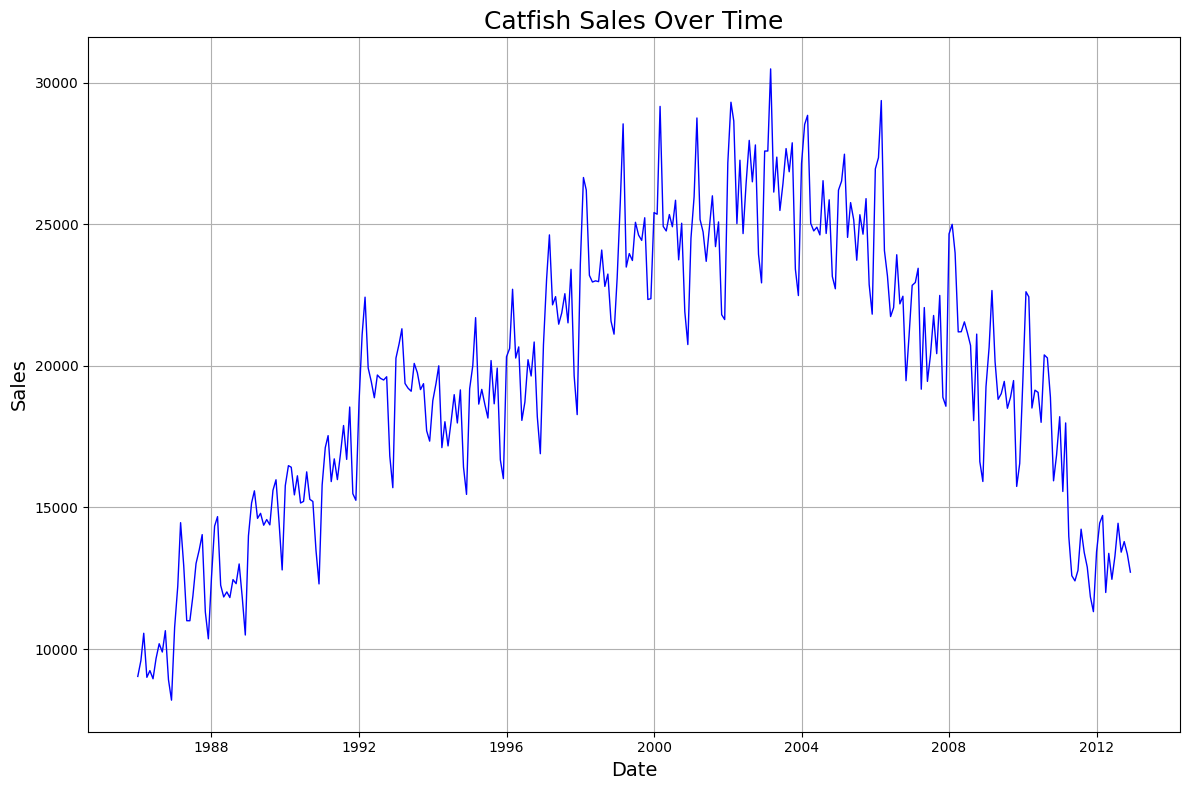

In [184]:
plt.figure(figsize=(12, 8))
plt.plot(catfish_sales['Date'], catfish_sales['Total'], color='blue', linewidth=1)
plt.title('Catfish Sales Over Time', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sales', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

### Decision:

The full dataset comprises multiple decades and exhibits a shifting trend: an initial period of steady growth in catfish sales followed by a significant decline. This kind of non-linear and non-stationary behavior makes it challenging to apply traditional time series models like SARIMA, which assume consistent seasonality and stationarity after transformations.

For this reason, we focus our analysis on a narrower time window — **1996 to 2000** — where:

+ the data appears more stable and locally stationary,

+ potential seasonality is easier to detect and model,

+ we avoid complications introduced by the long-term trend reversal.

By narrowing the time frame, we can apply classical time series models more effectively and obtain more reliable short-term forecasts.


In [185]:
catfish_sales.head()

,Date,Total
0,1986-01-01,9034
1,1986-02-01,9596
2,1986-03-01,10558
3,1986-04-01,9002
4,1986-05-01,9239


### Convert:

Remove the `Date` column, which had the datetime format, and convert the index into a `DateTimeIndex`, placing those dates into it. We want to determinate month frequency.

### What are the advantages of setting a DatetimeIndex in Pandas?
+ Pandas knows that the data is ordered in time.
+ `plt.plot(df)` automatically displays the X-axis as dates, not numbers.
+ Time-based filtering and selection:

```python
df['1996']              # entire year 1996
df['1996-03']           # March 1996
df['1996-01':'1997-01'] # time slice
```

+ With a `DatetimeIndex`, you can easily calculate things like quarterly averages:
+ Methods like `.rolling()`, `.shift()`, and `.asfreq()` work smoothly.


In [186]:
catfish_sales['Date'] = pd.to_datetime(catfish_sales['Date'])  # Date column
catfish_sales.set_index('Date', inplace=True)                  # Date column as index
catfish_sales = catfish_sales.asfreq('MS')                     # Frequency as month
catfish_sales.head()

,Total
Date,
1986-01-01,9034
1986-02-01,9596
1986-03-01,10558
1986-04-01,9002
1986-05-01,9239


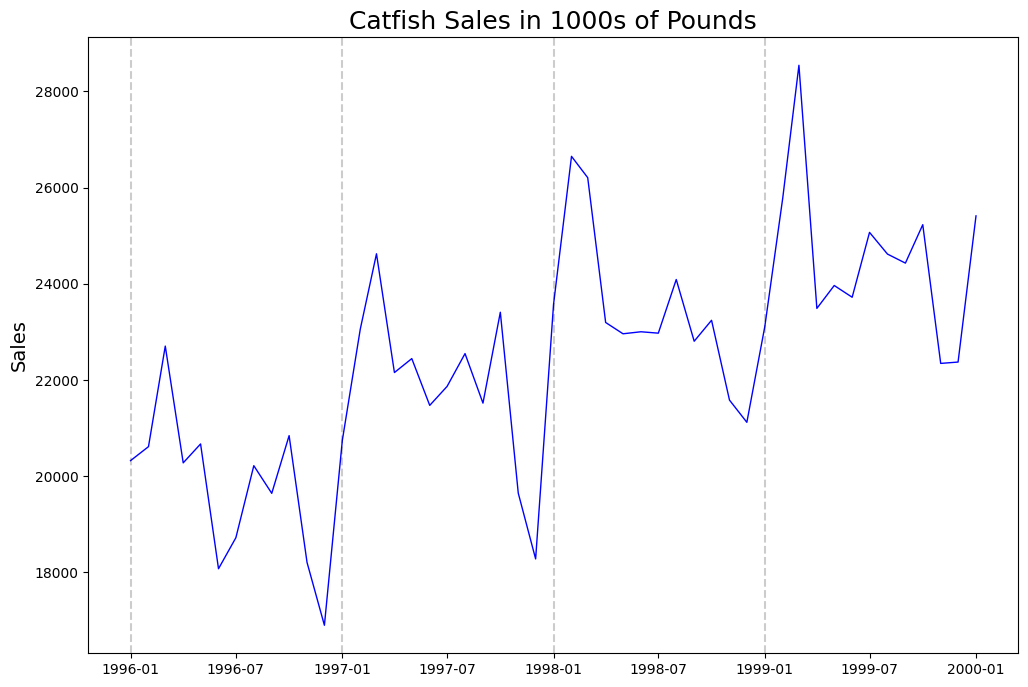

In [187]:
# Import
from datetime import datetime

# Zakres dat jako daty

start_date = pd.to_datetime('1996-01-01')
end_date = pd.to_datetime('2000-01-01')

# Filtrowanie po indeksie czasu
lim_catfish_sales = catfish_sales[start_date:end_date]

# Plot
plt.figure(figsize=(12,8))
plt.plot(lim_catfish_sales, color='blue', linewidth=1)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=18)
plt.ylabel('Sales', fontsize=14)

# Vertical lines for every year on plot
for year in range(start_date.year, end_date.year):
    plt.axvline(datetime(year, 1, 1), color='k', linestyle='--', alpha=0.2)

### Let's verify mathematically whether the time series are stationary:

We use ADF (Augmented Dickey-Fuller) tests, which are designed to assess the stationarity of a time series.

It tests the following hypotheses:

+ H₀ (null hypothesis): the series is not stationary (contains a unit root, i.e., has a trend).

+ H₁ (alternative hypothesis): the series is stationary.

By analyzing the test statistic and the corresponding p-value, we can determine whether to reject the null hypothesis and conclude that the series is stationary.

In [188]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(lim_catfish_sales)

print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -2.3427163739083654
p-value: 0.1585608264305401


$p-value > alfa = 0.05$

We accept the null hypothesis $H_{0}$ - The series is not stationary

### Remove the Trend – Data Do Not Meet Stationarity Conditions

+ To obtain `p` and `q`

In [189]:
first_diff = catfish_sales.diff().dropna()

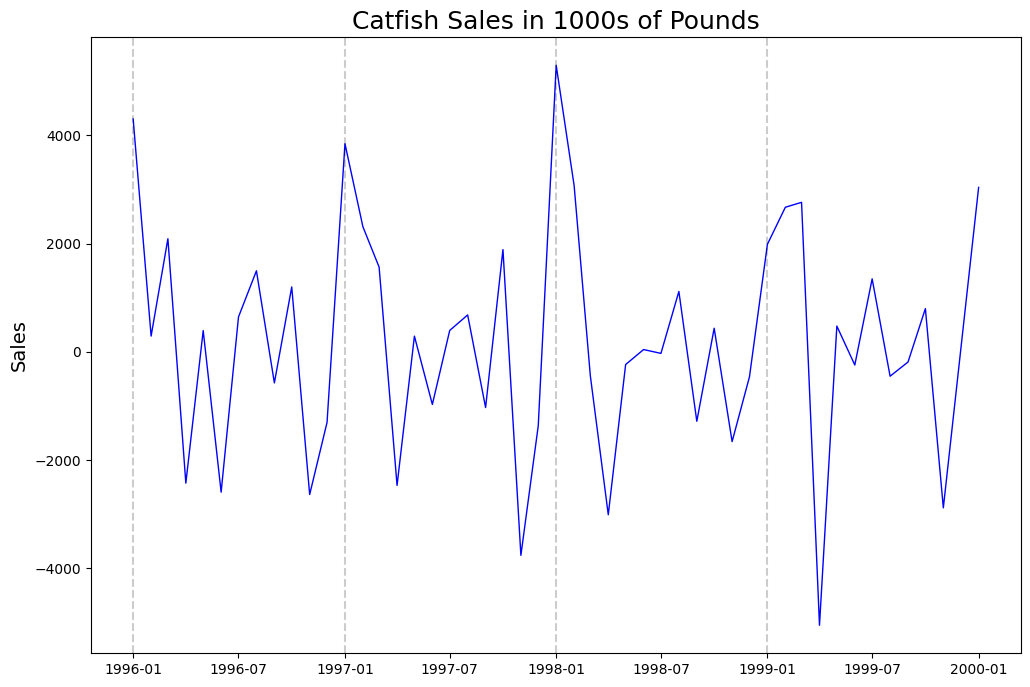

In [190]:
# Import
from datetime import datetime

# Zakres dat jako daty

start_date = pd.to_datetime('1996-01-01')
end_date = pd.to_datetime('2000-01-01')

# Filtrowanie po indeksie czasu
lim_first_diff = first_diff[start_date:end_date]

# Plot
plt.figure(figsize=(12,8))
plt.plot(lim_first_diff, color='blue', linewidth=1)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=18)
plt.ylabel('Sales', fontsize=14)

# Vertical lines for every year on plot
for year in range(start_date.year, end_date.year):
    plt.axvline(datetime(year, 1, 1), color='k', linestyle='--', alpha=0.2)

### ACF & PACF

+ Based on ACF, we should start with a seasonal MA process
+ Based on PACF, we should start with a seasonal AR process


<Figure size 1200x800 with 0 Axes>

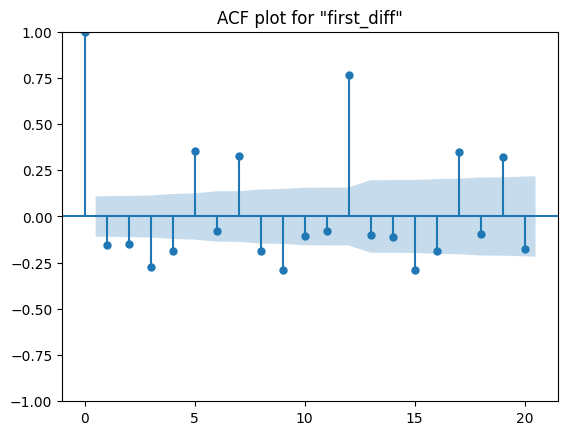

<Figure size 1200x800 with 0 Axes>

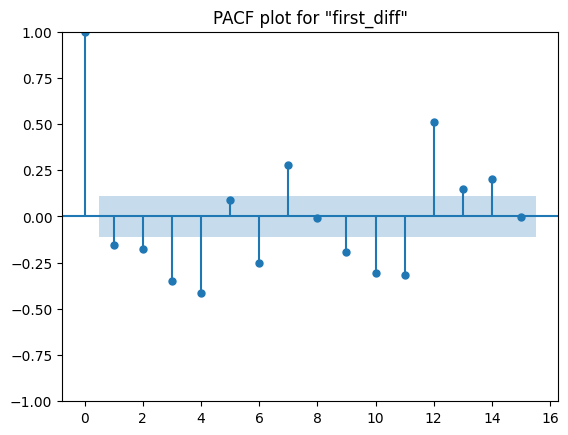

In [191]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12,8))
plot_acf(first_diff, lags=20)
plt.title('ACF plot for "first_diff"')
plt.show()

plt.figure(figsize=(12,8))
plot_pacf(first_diff, lags=15)
plt.title('PACF plot for "first_diff"')
plt.show()

### Let's verify mathematically whether the time series are stationary:


In [192]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(lim_first_diff)

print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -9.57210789641079
p-value: 2.2737112614443087e-16


$p-value < alfa = 0.05$

We reject the null hypothesis $H_{0}$ - The series is stationary

### Remove the trend and seasonality – Data do not meet stationarity conditions:

+ To obtain `P` and `Q`

In [193]:
first_diff_season = catfish_sales.diff().diff(12).dropna()

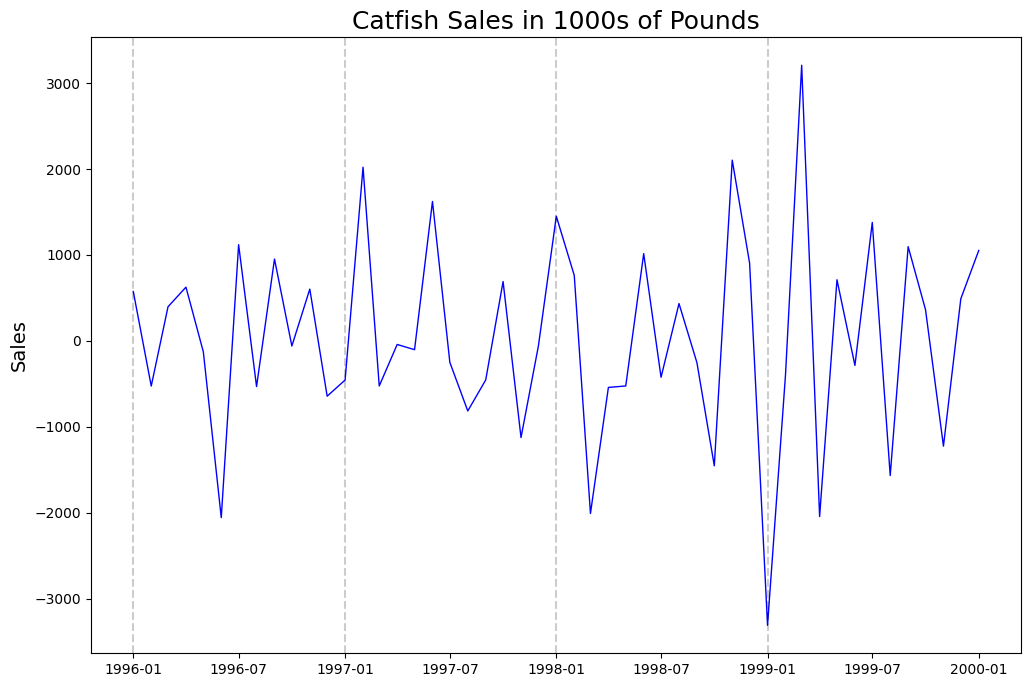

In [194]:
# Import
from datetime import datetime

# Zakres dat jako daty

start_date = pd.to_datetime('1996-01-01')
end_date = pd.to_datetime('2000-01-01')

# Filtrowanie po indeksie czasu
lim_first_diff = first_diff_season[start_date:end_date]

# Plot
plt.figure(figsize=(12,8))
plt.plot(lim_first_diff, color='blue', linewidth=1)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=18)
plt.ylabel('Sales', fontsize=14)

# Vertical lines for every year on plot
for year in range(start_date.year, end_date.year):
    plt.axvline(datetime(year, 1, 1), color='k', linestyle='--', alpha=0.2)

### ACF & PACF:

+ Based on ACF, we should start with a seasonal MA process
+ Based on PACF, we should start with a seasonal AR process

<Figure size 1200x800 with 0 Axes>

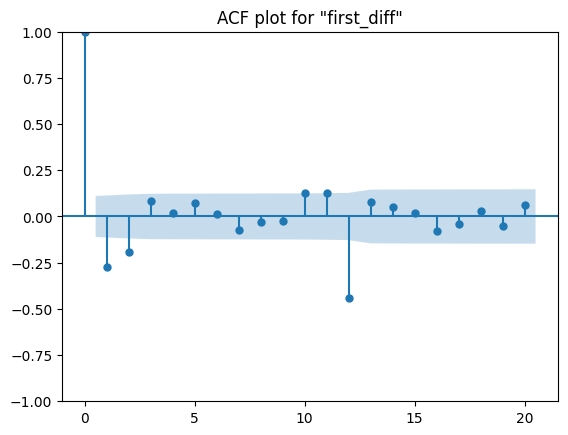

<Figure size 1200x800 with 0 Axes>

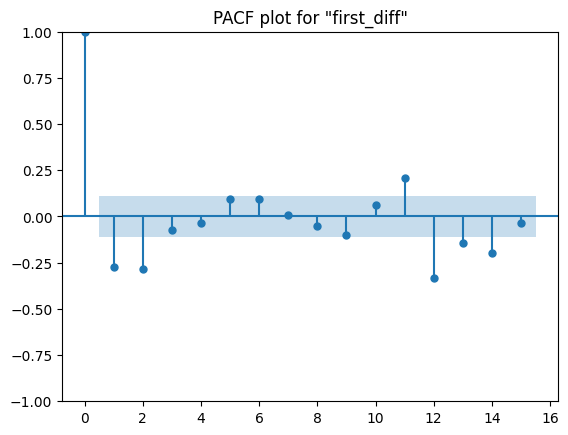

In [195]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12,8))
plot_acf(first_diff_season, lags=20)
plt.title('ACF plot for "first_diff"')
plt.show()

plt.figure(figsize=(12,8))
plot_pacf(first_diff_season, lags=15)
plt.title('PACF plot for "first_diff"')
plt.show()

### Train set and test sets:

The model is trained on the raw, non-stationary data, as both trend and seasonality are handled internally by the differencing parameters. The parameter d determines the number of non-seasonal differences applied to remove trend, while `D` specifies the number of seasonal differences used to eliminate recurring seasonal patterns. The parameters `p` and `q` represent the non-seasonal autoregressive and moving average terms, respectively, whereas `P` and `Q` serve the same purpose for the seasonal component, with s indicating the length of the seasonal cycle.

In [196]:
# Lets assume that: "lim_catfish_sales" is smaller scope (1996–2000).

# Date of train end:
train_end_date = '1999-06-01'

# Train data up to 1999-06-01:
train_data = lim_catfish_sales.loc[:train_end_date]

# Test data from 1999-07-01:
test_data = lim_catfish_sales.loc['1999-06-01':]

print("Extent of train data :", train_data.index.min(), "up to", train_data.index.max())
print("Extent of test data:", test_data.index.min(), "up to", test_data.index.max())
print(test_data)

Extent of train data : 1996-01-01 00:00:00 up to 1999-06-01 00:00:00
Extent of test data: 1999-06-01 00:00:00 up to 2000-01-01 00:00:00
            Total
Date             
1999-06-01  23720
1999-07-01  25069
1999-08-01  24618
1999-09-01  24430
1999-10-01  25229
1999-11-01  22344
1999-12-01  22372
2000-01-01  25412


### SARIMA Model:

In [197]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit the model
model = SARIMAX(train_data, order=(0, 1, 1), seasonal_order=(1, 1, 0, 12))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               Total   No. Observations:                   42
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 12)   Log Likelihood                -242.581
Date:                             Sun, 22 Jun 2025   AIC                            491.163
Time:                                     21:48:32   BIC                            495.265
Sample:                                 01-01-1996   HQIC                           492.447
                                      - 06-01-1999                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5558      0.123     -4.507      0.000      -0.798      -0.314
ar.S.L12      -0.2875      

The SARIMA(0,1,1)×(1,1,0,12) model was fitted to the training data. All estimated parameters (ma.L1 and ar.S.L12) are statistically significant (p < 0.05), indicating that they contribute meaningfully to the model.

The Ljung-Box test (p = 0.37) suggests no significant autocorrelation in the residuals, and the Jarque-Bera test (p = 0.57) indicates no major departures from normality. Heteroskedasticity was also not detected.

Conclusion: the model fits the data well, and the residuals do not exhibit systematic patterns. It is appropriate to proceed to the forecasting stage.

### Forecast:

In [198]:
# Get the predictions and residuals
start = len(train_data) - 1
end = start + len(test_data) - 1
forecast = model_fit.predict(start=start, end=end)

print("Forecasted values:\n", forecast)

Forecasted values:
 1999-06-01    23759.465005
1999-07-01    23834.824014
1999-08-01    24826.060093
1999-09-01    23615.078609
1999-10-01    24469.066491
1999-11-01    22204.507676
1999-12-01    21482.343279
2000-01-01    24421.883781
Freq: MS, Name: predicted_mean, dtype: float64


### Forecast visualization:

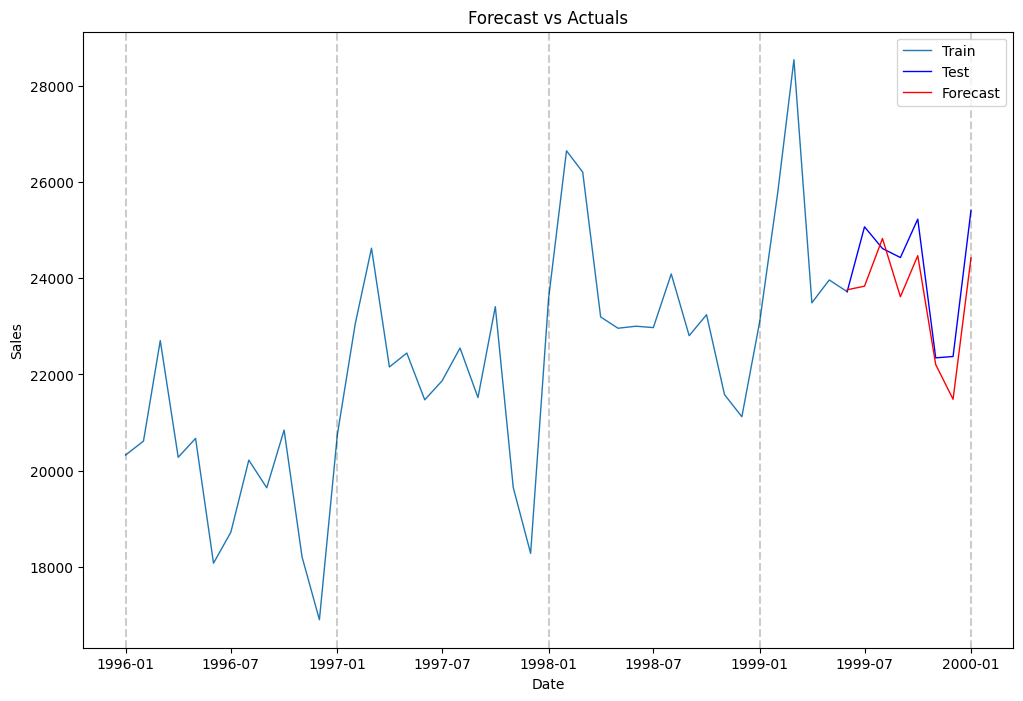

In [199]:
plt.figure(figsize=(12, 8))
plt.plot(train_data, label='Train', linewidth=1)
plt.plot(test_data, label='Test', color='blue', linewidth=1)
plt.plot(forecast, label='Forecast', color='red', linewidth=1)
plt.title('Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()

for year in range(start_date.year, end_date.year + 1):
    plt.axvline(datetime(year, 1, 1), color='k', linestyle='--', alpha=0.2)

In [200]:
residuals = test_data['Total'] - forecast
residuals.name = 'Residuals'
residuals.head()

Date
1999-06-01     -39.465005
1999-07-01    1234.175986
1999-08-01    -208.060093
1999-09-01     814.921391
1999-10-01     759.933509
Freq: MS, Name: Residuals, dtype: float64

In [201]:
test_data.head()

,Total
Date,
1999-06-01,23720
1999-07-01,25069
1999-08-01,24618
1999-09-01,24430
1999-10-01,25229


In [202]:
forecast.head()

1999-06-01    23759.465005
1999-07-01    23834.824014
1999-08-01    24826.060093
1999-09-01    23615.078609
1999-10-01    24469.066491
Freq: MS, Name: predicted_mean, dtype: float64

### Evaluation:

In [203]:
mape = np.mean(np.abs(residuals / test_data['Total'])) * 100
rmse = np.sqrt(np.mean(residuals**2))

print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")

MAPE: 2.60%
RMSE: 758.36


Text(0, 0.5, 'Error')

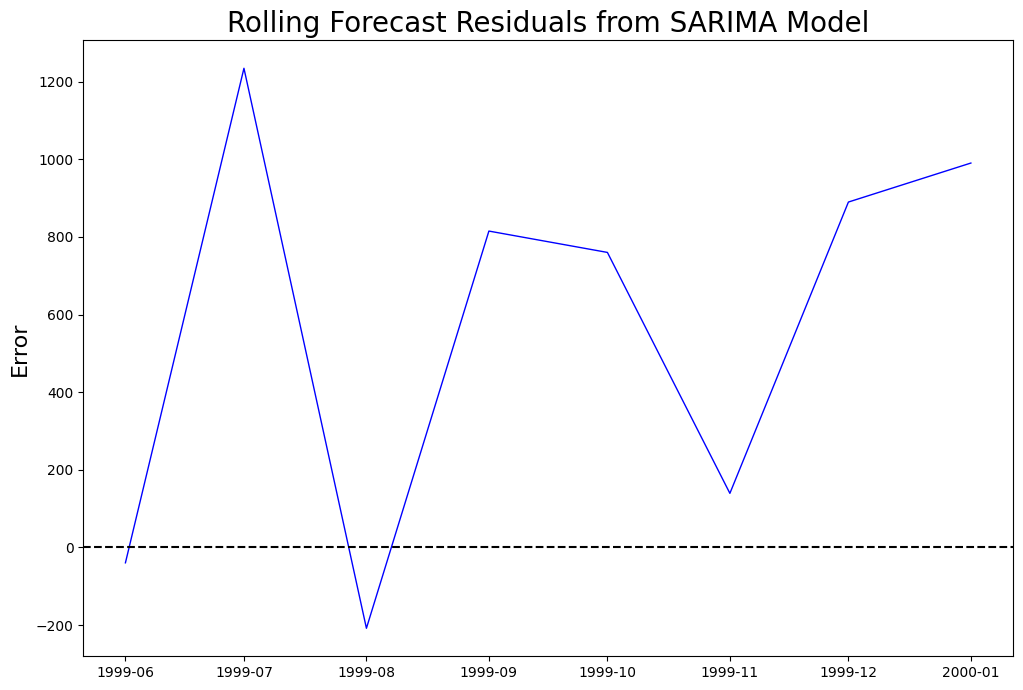

In [204]:
plt.figure(figsize=(12,8))
plt.plot(residuals, color='blue', linewidth=1)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

### Using the Rolling Forecast Origin

A rolling forecast is a technique used to evaluate time series models by repeatedly updating predictions step by step, mimicking real-world forecasting where new data becomes available over time.



In [205]:
test_data.index

DatetimeIndex(['1999-06-01', '1999-07-01', '1999-08-01', '1999-09-01',
               '1999-10-01', '1999-11-01', '1999-12-01', '2000-01-01'],
              dtype='datetime64[ns]', name='Date', freq='MS')

In [206]:
from datetime import timedelta

rolling_predictions = []  # Store predictions here

for test_point in test_data.index:
    # Extend training data to include everything *up to one step before* the current test point
    # We subtract 1 day – since we're using 'MS' frequency, this smartly moves one month back
    train_data = lim_catfish_sales.loc[:test_point - timedelta(days=1)]

    # Fit the model on the current training subset
    model = SARIMAX(train_data, order=(0, 1, 1), seasonal_order=(1, 1, 0, 12))
    model_fit = model.fit(disp=False)

    # Forecast only 1 step ahead
    pred = model_fit.forecast(steps=1)

    # Store the forecasted value
    rolling_predictions.append(pred.values[0])

# Create a series from the rolling forecasts, aligned with the test data
rolling_forecast = pd.Series(rolling_predictions, index=test_data.index)
print(rolling_forecast)

Date
1999-06-01    23754.794950
1999-07-01    23834.824014
1999-08-01    25373.458747
1999-09-01    23831.814798
1999-10-01    24942.652911
1999-11-01    22763.734603
1999-12-01    21842.227440
2000-01-01    25046.875579
Freq: MS, dtype: float64


Text(0, 0.5, 'Error')

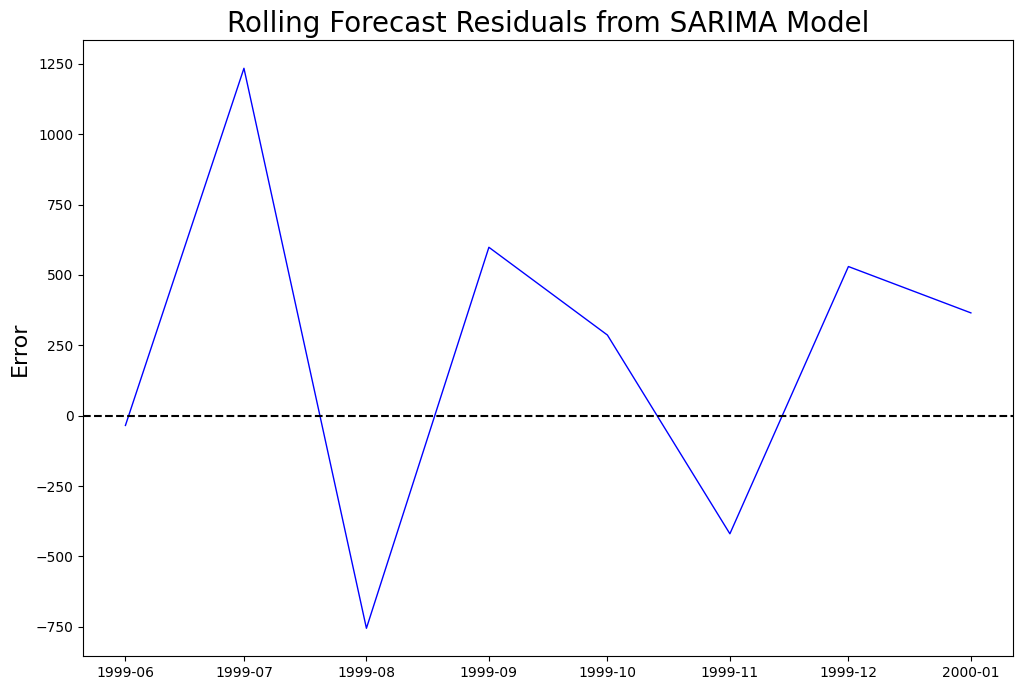

In [207]:
rolling_residuals = test_data['Total'] - rolling_forecast

plt.figure(figsize=(12,8))
plt.plot(rolling_residuals, color="blue" , linewidth=1)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

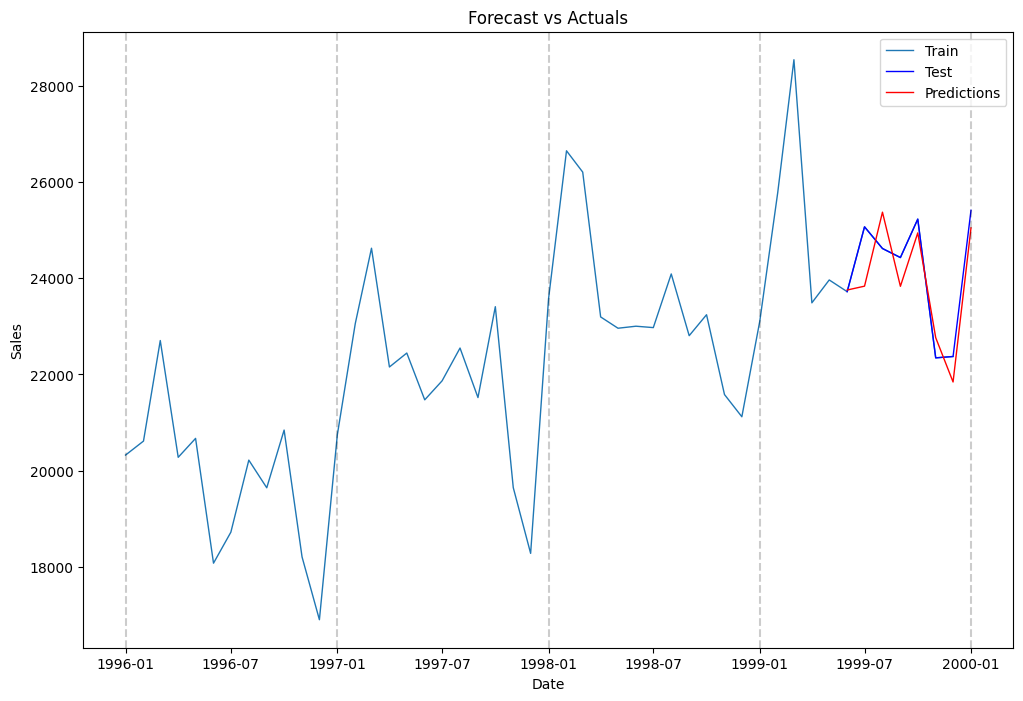

In [208]:
plt.figure(figsize=(12, 8))
plt.plot(train_data, label='Train', linewidth=1)
plt.plot(test_data, label='Test', color='blue', linewidth=1)
plt.plot(rolling_forecast, label='Predictions', color='red', linewidth=1)
plt.title('Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()

for year in range(start_date.year, end_date.year + 1):  # +1, by objąć też end_date
    plt.axvline(datetime(year, 1, 1), color='k', linestyle='--', alpha=0.2)

In [209]:
mape = round(np.mean(np.abs(rolling_residuals / test_data['Total'])) * 100, 2)
print('Mean Absolute Percent Error:', mape, '%')

Mean Absolute Percent Error: 2.18 %


In [210]:
rmse = np.sqrt(np.mean(rolling_residuals ** 2))
print('Root Mean Squared Error:', rmse)

Root Mean Squared Error: 625.0091107131803


### SARIMAX model:

With new independent variable - Season temperature - Exog parameter (to regression).

In [211]:
catfish_sales_temp = pd.read_csv(
    'catfish/catfish_with_temp.csv',
    parse_dates=['Date'],
    dayfirst=True
)
catfish_sales_temp.head()

,Date,Total,season_temp
0,1986-01-01,9034,20.000000
1,1986-02-01,9596,23.660254
2,1986-03-01,10558,25.000000
3,1986-04-01,9002,23.660254
4,1986-05-01,9239,20.000000


In [212]:
catfish_sales_temp['Date'] = pd.to_datetime(catfish_sales_temp['Date'])
catfish_sales_temp.head()

,Date,Total,season_temp
0,1986-01-01,9034,20.000000
1,1986-02-01,9596,23.660254
2,1986-03-01,10558,25.000000
3,1986-04-01,9002,23.660254
4,1986-05-01,9239,20.000000


In [213]:
catfish_sales_temp.set_index('Date', inplace=True)
catfish_sales_temp.head()

,Total,season_temp
Date,,
1986-01-01,9034,20.000000
1986-02-01,9596,23.660254
1986-03-01,10558,25.000000
1986-04-01,9002,23.660254
1986-05-01,9239,20.000000


In [214]:
catfish_sales = catfish_sales_temp.asfreq('MS')
catfish_sales.head()

,Total,season_temp
Date,,
1986-01-01,9034,20.000000
1986-02-01,9596,23.660254
1986-03-01,10558,25.000000
1986-04-01,9002,23.660254
1986-05-01,9239,20.000000


### Same steps ...

In [215]:
print("Extent of train data :", train_data.index.min(), "up to", train_data.index.max())
print("Extent of test data:", test_data.index.min(), "up to", test_data.index.max())

Extent of train data : 1996-01-01 00:00:00 up to 1999-12-01 00:00:00
Extent of test data: 1999-06-01 00:00:00 up to 2000-01-01 00:00:00


In [216]:
train_exog = catfish_sales.loc['1996-01-01':'1999-12-01', 'season_temp']

# Fit the model
model = SARIMAX(endog = train_data, exog = train_exog, order=(0, 1, 0), seasonal_order=(0, 1, 0, 12), measurement_error=True)
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())


                                     SARIMAX Results                                      
Dep. Variable:                              Total   No. Observations:                   48
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -291.267
Date:                            Sun, 22 Jun 2025   AIC                            588.534
Time:                                    21:48:38   BIC                            593.200
Sample:                                01-01-1996   HQIC                           590.144
                                     - 12-01-1999                                         
Covariance Type:                              opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
season_temp             665.1864    219.024      3.037      0.002     235.908    1094.465
va